In [1]:
import modin.pandas as mipd
import os
import time
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [2]:
time_resolution = '1week'

## Technique Network

+ View the Dataset here, read from the saved csv
++ Route('/mnt/data0/lkyin/network_data/emails/')

In [3]:
c_path = './weekly_data/commits/'
projects = os.listdir(c_path)

In [4]:
len(projects)

14300

In [5]:
proj_names = []
for project in tqdm(projects):
    project_name, period = project.replace('.csv', '').split('__')
    proj_names.append(project_name)

pd_proj_names = pd.Series(proj_names)
pd_proj_names.describe()

100%|██████████| 14300/14300 [00:00<00:00, 800717.53it/s]


count       14300
unique        263
top       jspwiki
freq          209
dtype: object

In [6]:
df_commits = pd.read_csv(c_path+projects[0])
df_commits.columns

Index(['project_name', 'list_name', 'date', 'month', 'message_id',
       'sender_name', 'sender_email', 'author_name', 'author_email',
       'file_name', 'loc', 'ref_or_sha', 'subject', 'commit_type',
       'incubation_time', 'author_full_name', 'is_bot', 'is_coding',
       'dealised_author_full_name', 'week'],
      dtype='object')

In [7]:
df_commits.describe()

,month,author_email,loc,ref_or_sha,incubation_time
count,52.0,0.0,52.000000,52.000000,52.0
mean,7.0,NaN,36.576923,651526.500000,21.0
std,0.0,NaN,145.137439,46.018965,0.0
min,7.0,NaN,0.000000,651503.000000,21.0
25%,7.0,NaN,0.000000,651504.000000,21.0
50%,7.0,NaN,0.000000,651504.000000,21.0
75%,7.0,NaN,3.000000,651504.000000,21.0
max,7.0,NaN,1012.000000,651628.000000,21.0


In [8]:
df_commits.head(5)

,project_name,list_name,date,month,message_id,sender_name,sender_email,author_name,author_email,file_name,loc,ref_or_sha,subject,commit_type,incubation_time,author_full_name,is_bot,is_coding,dealised_author_full_name,week
0,sling,commits,2008-04-25 06:37:18,7,<20080425063719.200641A9832@eris.apache.org>,cziegeler,cziegeler@apache.org,cziegeler,NaN,incubator/sling/trunk/parent/pom.xml,6.0,651503.0,svn commit: r651503 - /incubator/sling/trunk/p...,svn,21.0,carsten ziegeler,False,False,carsten ziegeler,2008-04-22/2008-04-28
1,sling,commits,2008-04-25 06:48:24,7,<20080425064832.310971A9832@eris.apache.org>,cziegeler,cziegeler@apache.org,cziegeler,NaN,incubator/sling/trunk/launchpad/base/,0.0,651504.0,svn commit: r651504 [1/2] - in /incubator/slin...,svn,21.0,carsten ziegeler,False,False,carsten ziegeler,2008-04-22/2008-04-28
2,sling,commits,2008-04-25 06:48:24,7,<20080425064832.310971A9832@eris.apache.org>,cziegeler,cziegeler@apache.org,cziegeler,NaN,incubator/sling/trunk/launchpad/base/DISCLAIMER,0.0,651504.0,svn commit: r651504 [1/2] - in /incubator/slin...,svn,21.0,carsten ziegeler,False,False,carsten ziegeler,2008-04-22/2008-04-28
3,sling,commits,2008-04-25 06:48:24,7,<20080425064832.310971A9832@eris.apache.org>,cziegeler,cziegeler@apache.org,cziegeler,NaN,incubator/sling/trunk/launchpad/base/LICENSE ...,0.0,651504.0,svn commit: r651504 [1/2] - in /incubator/slin...,svn,21.0,carsten ziegeler,False,False,carsten ziegeler,2008-04-22/2008-04-28
4,sling,commits,2008-04-25 06:48:24,7,<20080425064832.310971A9832@eris.apache.org>,cziegeler,cziegeler@apache.org,cziegeler,NaN,incubator/sling/trunk/launchpad/base/NOTICE ...,0.0,651504.0,svn commit: r651504 [1/2] - in /incubator/slin...,svn,21.0,carsten ziegeler,False,False,carsten ziegeler,2008-04-22/2008-04-28


## ASF Techinical Network Construction from Likang
+ Using NetworkX for analysis
    + https://www.osgeo.cn/networkx/tutorial.html#attributes

    + Use Pandas with NetworkX https://www.jianshu.com/p/11456474d8a5

+ How this network is constructed (Data already saved as commits for each project each month):
    + Tow features: "is_bot" as False and "is_coding" as True
    + Author is not null (SVN has 'noauthor')
    + For each row:
        + Check if file name exist as node
        + Add file as Node
        + Edges saved in technical_net as a set
        + for each commit on each file, weight +1
    + Use technical_net to construct graph
        + Network attributes from the dictionary: https://www.osgeo.cn/networkx/tutorial.html#attributes

In [32]:
c_path = './weekly_data/commits/'
projects = os.listdir(c_path)
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
to_path = './network_data'+time_resolution+'/commits/'
if not os.path.exists(to_path):
    os.makedirs(to_path)
gx_technets = []
for project in tqdm(projects):
    technical_net = {}
    project_name, period = project.replace('.csv', '').split('__')
    if (int(period))%(int(time_resolution[0]))!=0 :
        continue
    fnames = [project_name+'__'+str(int(period)+i).zfill(3)+'.csv' for i in range(int(time_resolution[0])) ]
    for fname in fnames:
        if not os.path.exists(c_path+fname):
            continue
        df = pd.read_csv(c_path+fname)
        df.query('is_bot == False and is_coding == True', inplace=True)
        df = df[df['dealised_author_full_name'].notna()]
        for index, row in df.iterrows():
            file_path = row['file_name']
            # file extension = '.' + file_path.split('/')[-1].split('.')[-1].split(' ')[0]
            file_name = file_path.split('/')[-1]
            author_name = row['dealised_author_full_name']
            if file_name not in technical_net:
                technical_net[file_name] = {}
            if author_name not in technical_net[file_name]:
                technical_net[file_name][author_name] = {}
                technical_net[file_name][author_name]['weight'] = 0
            technical_net[file_name][author_name]['weight'] += 1

    #save as directed graph
    g = nx.DiGraph(technical_net)
    # add disconnected nodes
    g.add_nodes_from(technical_net.keys())
    nx.write_edgelist(g, to_path + '{}__{}.edgelist'.format(project_name, str(period)), delimiter='##', data=["weight"])
    gx_technets.append(g)

100%|██████████| 14300/14300 [02:14<00:00, 106.63it/s]


In [35]:
int(time_resolution[0])

3

In [38]:
technical_net

{}

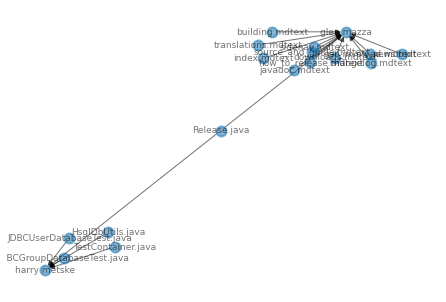

In [37]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(g,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)

## ASF Social Networks Construction From Likang

+ How this network is constructed (Data already saved as commits for each project each month):
    + Tow features: "is_bot" as False and "is_coding" as True
    + Author is not null
    + For each email:
        + Check if this email have previous references, if not, quit and go next
        + Add previous authors as Nodes
        + Edges saved in social_net as a node
        + for each email sent to previous edges on each file, mutually (sender to previous & previous to sender) weight +1

In [24]:
e_path = '/mnt/data0/lkyin/monthly_data/emails/'
projects = os.listdir(e_path)

In [25]:
for project in tqdm(projects[:1]):

    social_net = {}
    emailID_to_author = {}
    project_name, period = project.replace('.csv', '').split('__')
    df = pd.read_csv(e_path+project)
    df.query('is_bot == False', inplace=True)
    df = df[df['dealised_author_full_name'].notna()]

100%|██████████| 1/1 [00:00<00:00, 40.69it/s]


In [26]:
df.columns

Index(['project_name', 'list_name', 'date', 'month', 'message_id',
       'sender_name', 'references', 'sender_email', 'in_reply_to', 'cc_list',
       'receiver_email', 'subject', 'body', 'from_commit', 'incubation_time',
       'author_full_name', 'is_bot', 'dealised_author_full_name'],
      dtype='object')

In [27]:
df.describe()

,month,incubation_time
count,175.0,175.0
mean,3.0,64.0
std,0.0,0.0
min,3.0,64.0
25%,3.0,64.0
50%,3.0,64.0
75%,3.0,64.0
max,3.0,64.0


In [28]:
df.head(5)

,project_name,list_name,date,month,message_id,sender_name,references,sender_email,in_reply_to,cc_list,receiver_email,subject,body,from_commit,incubation_time,author_full_name,is_bot,dealised_author_full_name
0,taverna,dev,2015-01-01 16:35:19,3.0,<20150101163522.23F3610B3D@minotaur.apache.org>,Marvin Humphrey,None,marvin@apache.org,None,None,dev@taverna.incubator.apache.org,January 2015 Report,"Greetings, {podling} developers,\n\nThe ""marvi...",False,64.0,marvin humphrey,False,marvin humphrey
1,taverna,dev,2015-01-05 10:36:33,3.0,<CAPRnXtku=FaDTVc0Kh+rse0VS3uSwNE1JMuQtyLajyLr...,Stian Soiland-Reyes,<54A2DF32.80604@gmail.com> <CAPRnXtnj7cyFEZFuA...,soiland-reyes@cs.manchester.ac.uk,<CAPRnXtnj7cyFEZFuAkWZ+ZZZub08BcUzPUi--XGuenuH...,None,dev@taverna.incubator.apache.org,Re: Scufl2 lib can parse t2flow when package w...,"Here's how I do shading in scufl2-wfdesc, a si...",False,64.0,stian soilandreyes,False,stian soilandreyes
2,taverna,dev,2015-01-05 10:55:01,3.0,<CAPRnXtnKLxB=9E9n6DcqTAxFs_YiJn=VyYk9rDcr2qUa...,Stian Soiland-Reyes,<20150101163522.23F3610B3D@minotaur.apache.org>,soiland-reyes@cs.manchester.ac.uk,<20150101163522.23F3610B3D@minotaur.apache.org>,None,"dev@taverna.incubator.apache.org, \n\tShoaib S...",Re: January 2015 Report,"I've started a draft report, based on December...",False,64.0,stian soilandreyes,False,stian soilandreyes
3,taverna,dev,2015-01-05 12:08:39,3.0,<CAPRnXtnrGC-1XNv=UrDaD2eUBe970VUX8T4C0gVX60oG...,Stian Soiland-Reyes,None,soiland-reyes@cs.manchester.ac.uk,None,None,dev@taverna.incubator.apache.org,Status: Taverna git staging - 45% done - pleas...,I've managed to get to a state of the staging ...,False,64.0,stian soilandreyes,False,stian soilandreyes
4,taverna,dev,2015-01-05 12:10:49,3.0,<CAOkCRcB_mbjz4BxS6Kx4vo0CS+s7pREqYg_zhyRtYg66...,Shoaib Sufi,None,shoaibsufi@gmail.com,None,None,dev@taverna.incubator.apache.org,University of Manchester signing of the Apache...,"Hi,\n\nI have had this information from the Un...",False,64.0,shoaib sufi,False,shoaib sufi


In [6]:
time_resolution = '3week'

to_path = './network_data'+time_resolution+'/emails/'
if not os.path.exists(to_path):
    os.makedirs(to_path)
e_path = './weekly_data/emails/'
projects = os.listdir(e_path)
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
gx_socialnets = []
for project in tqdm(projects):

    social_net = {}
    emailID_to_author = {}
    project_name, period = project.replace('.csv', '').split('__')
    if int(period)%int(time_resolution[0])!=0 :
        continue
    fnames = [project_name+'__'+str(int(period)+i).zfill(3)+'.csv' for i in range(int(time_resolution[0])) ]
    for fname in fnames:
        if not os.path.exists(e_path+fname):
            continue
        df = pd.read_csv(e_path+fname)
        df.query('is_bot == False', inplace=True)
        df = df[df['dealised_author_full_name'].notna()]
        
        for index, row in df.iterrows():
            message_id = row['message_id'].strip()
            # print(row['dealised_author_full_name'])
            sender_name = row['dealised_author_full_name']
            emailID_to_author[message_id] = sender_name

        # raise KeyError
        for index, row in df.iterrows():
            message_id = row['message_id']
            references = row['references']
            sender_name = row['dealised_author_full_name']

            # ignores if this email does not to previous emails
            if pd.isna(references) or references == 'None':
                continue

            references = [r.strip() for r in references.replace('\n', ' ').replace('\t', ' ').split(' ') if r.strip()]

            # deal with the issue that a line breaker exists in message_id:
            # e.g., <4\n829AB62.6000302@apache.org>
            new_refs = set()
            for i in range(len(references)-1):
                if '<' in references[i] and '>' not in references[i] and '<' not in references[i+1] and '>' in references[i+1]:
                    new_refs.add(references[i] + references[i+1])
            for r in references:
                if '<' in r and '>' in r:
                    new_refs.add(r)

            references = new_refs
            for reference_id in references:
                if reference_id not in emailID_to_author:
                    continue
                prev_author = emailID_to_author[reference_id]
                # if it's the same person, continue
                if prev_author == sender_name:
                    continue
                if sender_name not in social_net:
                    social_net[sender_name] = {}
                if prev_author not in social_net:
                    social_net[prev_author] = {}

                # if node B replies node A, it means B sends signal to A
                if prev_author not in social_net[sender_name]:
                    social_net[sender_name][prev_author] = {}
                    social_net[sender_name][prev_author]['weight'] = 0
                social_net[sender_name][prev_author]['weight'] += 1

                # if node B replies node A, it means A also sent signal to B
                if sender_name not in social_net[prev_author]:
                    social_net[prev_author][sender_name] = {}
                    social_net[prev_author][sender_name]['weight'] = 0
                social_net[prev_author][sender_name]['weight'] += 1

    #save as directed graph
    g = nx.DiGraph(social_net)
    # add disconnected nodes
    g.add_nodes_from(social_net.keys())
    nx.write_edgelist(g, to_path + '{}__{}.edgelist'.format(project_name, str(period)), delimiter='##', data=["weight"])
    gx_socialnets.append(g)

100%|██████████| 23095/23095 [04:17<00:00, 89.71it/s] 


In [10]:
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
projects

['abdera__0.csv',
 'accumulo__0.csv',
 'activemq__0.csv',
 'adffaces__0.csv',
 'airavata__0.csv',
 'amaterasu__0.csv',
 'ant__0.csv',
 'any23__0.csv',
 'apex__0.csv',
 'apisix__0.csv',
 'aries__0.csv',
 'atlas__0.csv',
 'aurora__0.csv',
 'awf__0.csv',
 'batchee__0.csv',
 'beam__0.csv',
 'beehive__0.csv',
 'bluesky__0.csv',
 'bookkeeper__0.csv',
 'brooklyn__0.csv',
 'buildr__0.csv',
 'bval__0.csv',
 'calcite__0.csv',
 'carbondata__0.csv',
 'cassandra__0.csv',
 'cayenne__0.csv',
 'celix__0.csv',
 'chemistry__0.csv',
 'chukwa__0.csv',
 'climate__0.csv',
 'cloudstack__0.csv',
 'cmda__0.csv',
 'commons__0.csv',
 'commonsrdf__0.csv',
 'concerted__0.csv',
 'corinthia__0.csv',
 'couchdb__0.csv',
 'ctakes__0.csv',
 'curator__0.csv',
 'cxf__0.csv',
 'daffodil__0.csv',
 'datafu__0.csv',
 'deltaspike__0.csv',
 'depot__0.csv',
 'derby__0.csv',
 'devicemap__0.csv',
 'directmemory__0.csv',
 'drill__0.csv',
 'droids__0.csv',
 'dubbo__0.csv',
 'echarts__0.csv',
 'esme__0.csv',
 'fineract__0.csv',
 'fli

In [55]:
social_net

{'poorna chandra': {'james taylor': {'weight': 12},
  'alan gates': {'weight': 4},
  'thomas dsilva': {'weight': 2}},
 'james taylor': {'poorna chandra': {'weight': 12},
  'alan gates': {'weight': 8},
  'thomas dsilva': {'weight': 4}},
 'alan gates': {'poorna chandra': {'weight': 4},
  'james taylor': {'weight': 8},
  'thomas dsilva': {'weight': 2}},
 'thomas dsilva': {'james taylor': {'weight': 4},
  'alan gates': {'weight': 2},
  'poorna chandra': {'weight': 2}},
 'andreas neumann': {'jeanmarc spaggiari': {'weight': 1}},
 'jeanmarc spaggiari': {'andreas neumann': {'weight': 1}}}

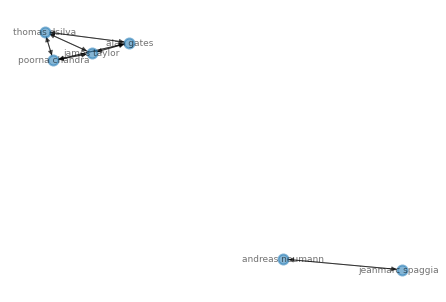

In [49]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(g,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)

## Analysis

### Overlap

In [60]:
gx_unionnets = []
adjmats = []
for i in range(len(gx_technets)):
    unionnet = nx.algorithms.operators.binary.union(gx_technets[i],gx_socialnets[i])
    gx_unionnets.append(unionnet)
    adjm = np.array(nx.adjacency_matrix(unionnet).todense())
    adjmats.append(adjm)


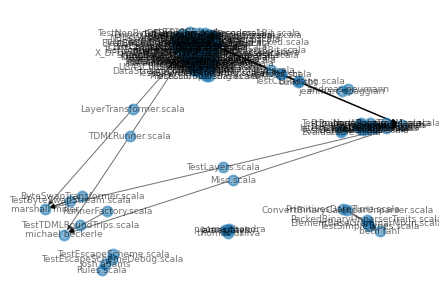

In [57]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(unionnet,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)

In [61]:
adjmats

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 5],
        [0, 0, 0, ..., 0, 5, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   